# Timeseries classification with CNN and Embeddings

This tutorial is the first part of building a timeseries model with PyTorch which combined a CNN with an embedding. This way we can not only use time-dependent data, but enrich it with categorical data. Unfortunately, I didn't find any open datasets where we have time dependent data AND categorical data attached to it, but I will build a categorical level on the fly to show you how to set up this kind of model.

In the next tutorial I want to show you the underlying code and how it works. This tutorial is about making the model work.

In [1]:
from common import *
from config import *
from dataloaders import *
from transform_data import *
from model_part import *
from callbacks import *

from functools import partial
from scipy.io import arff
import matplotlib.pyplot as plt

In [2]:
# Read data
data_train = arff.loadarff('data/LargeKitchenAppliances_TRAIN.arff')
data_test = arff.loadarff('data/LargeKitchenAppliances_TEST.arff')
df_test = pd.DataFrame(data_test[0])
df_train = pd.DataFrame(data_train[0])

# let's add a categorical variable
countries = ['Germany', 'US']
household_income = ['low', 'high']
df_train["country"] = np.random.choice(countries, len(df_train))
df_test["country"] = np.random.choice(countries, len(df_test))
df_train["household_income"] = np.random.choice(household_income, len(df_train))
df_test["household_income"] = np.random.choice(household_income, len(df_test))

df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att714,att715,att716,att717,att718,att719,att720,target,country,household_income
0,-0.099108,-0.099108,-0.099108,-0.099108,-0.099108,-0.099108,-0.099108,-0.099108,-0.099108,-0.099108,...,-0.099108,-0.099108,-0.099108,-0.099108,-0.099108,-0.099108,-0.099108,b'1',US,low
1,-0.155256,-0.155256,-0.155256,-0.155256,-0.155256,-0.155256,-0.155256,-0.155256,-0.155256,-0.155256,...,-0.155256,-0.155256,-0.155256,-0.155256,-0.155256,-0.155256,-0.155256,b'1',Germany,high
2,-0.100082,-0.100082,-0.100082,-0.100082,-0.100082,-0.100082,-0.100082,-0.100082,-0.100082,-0.100082,...,-0.100082,-0.100082,-0.100082,-0.100082,-0.100082,-0.100082,-0.100082,b'1',Germany,high
3,-0.140671,-0.140671,-0.140671,-0.140671,-0.140671,-0.140671,-0.140671,-0.140671,-0.140671,-0.140671,...,-0.140671,-0.140671,-0.140671,-0.140671,-0.140671,-0.140671,-0.140671,b'1',US,high
4,-0.140576,-0.140576,-0.140576,-0.140576,-0.140576,-0.140576,-0.140576,-0.140576,-0.140576,-0.140576,...,-0.140576,-0.140576,-0.140576,-0.140576,-0.140576,-0.140576,-0.140576,b'1',Germany,high


In [3]:
df_train.shape, df_test.shape

((375, 723), (375, 723))

The first 720 columns represent the time-dependent variables, the second last is our target_variable and the last is our (fake) categorical variable.

In [4]:
x_train = df_train.iloc[:, :-3].values.reshape(-1, 1, 720)
x_test = df_test.iloc[:, :-3].values.reshape(-1, 1, 720)

y_train = df_train.iloc[:, -3].values
y_test = df_test.iloc[:, -3].values

emb_vars_train = df_train.iloc[:, -2:].values
emb_vars_test = df_test.iloc[:, -2:].values

Let's plot some of these:

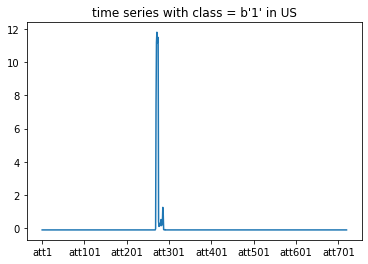

In [5]:
df_train.iloc[0, :-3].plot.line(title=f'time series with class = {df_train.iloc[0, -3]} in {df_train.iloc[0, -2]}');

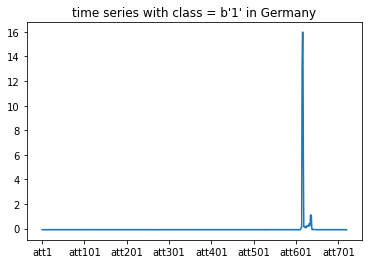

In [6]:
df_train.iloc[10, :-3].plot.line(title=f'time series with class = {df_train.iloc[10, -3]} in {df_train.iloc[10, -2]}');

Let's check the means and variance of our variables:

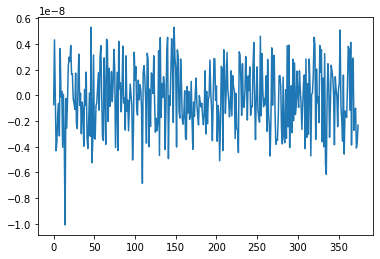

In [7]:
plt.plot(x_train.mean(axis=2).reshape(-1))

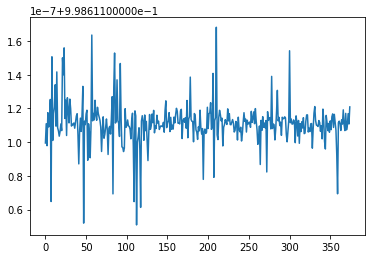

In [8]:
plt.plot(x_train.var(axis=2).reshape(-1))

Note the 1e-8 on top, meaning we're dealing here with numbers almost being 0 for the mean and almost being 1 for the variance, so we do not need to normalize them, because they already are. Still, I want to show you a neat trick of how to use broadcasting to quickly normalize each column to have mean of zero and variance of 1:

In [9]:
def normalize(x, m, s): return (x-m)/s

means_ = x_train.mean(axis=2)
vars_ = x_train.var(axis=2)

In [10]:
means_.shape, vars_.shape, x_train.shape

((375, 1), (375, 1), (375, 1, 720))

Only the last dimensions does not match, therefore we can use broadcasting to normalize over all columns:

In [11]:
normalize(x_train, means_, vars_).shape

(375, 375, 720)

Again, in this case our data already looks as it should. Also, the kind of function like *normalize* I put into a .py file with the name common, which can then be imported by any other python-file or notebook, just as I did right on top of this notebook. So whenever in this notebook there appears a function which is not defined so far, look into the *common.py* file.

As a next step, we need to transform the target variable and the categorical variable into something the computer can actuelly work with, meaning a number. We can do this using the *cat_transform* function:

In [12]:
y_train, y_test, dict_y, dict_inv_y = cat_transform(y_train, y_test)
emb_vars_train, emb_vars_test, dict_embs, dict_inv_embs = cat_transform(emb_vars_train, emb_vars_test)


In [13]:
y_train[:10], emb_vars_train[:10], dict_y, dict_embs

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([[0, 1],
        [1, 0],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1]]),
 [{0: b'2', 1: b'1', 2: b'3'}],
 [{0: 'US', 1: 'Germany'}, {0: 'high', 1: 'low'}])

In [14]:
dict_y, dict_embs

([{0: b'2', 1: b'1', 2: b'3'}],
 [{0: 'US', 1: 'Germany'}, {0: 'high', 1: 'low'}])

Next, we will use PyTorch to create dataset and dataloader, which we will put into a class called DataBunch (idea stolen from fastai).

In [15]:
device = DEVICE
datasets = create_datasets(x_train, emb_vars_train, y_train,
             x_test, emb_vars_test, y_test,
             valid_pct=VAL_SIZE, seed=1234)
data = DataBunch(*create_loaders(datasets, bs=1024))

Next, we define our model. First, we need to make sure that the final convolution ends up with 1 as the last dimension, so we can put it through a linear layer.

In [16]:
# define model
raw_feat = x_train.shape[1]
emb_dims = [(len(dict_embs[0]), EMB_DIMS), (len(dict_embs[1]), EMB_DIMS)]

num_classes = len(dict_y[0])

Let's grab a batch from our data and see how the convolutions work on our timeseries data:

In [17]:
x_raw, _, _ = next(iter(data.train_dl))
x_raw.shape

torch.Size([300, 1, 720])

In [18]:
raw_ni=x_train.shape[1] # no of input features (here:1)
drop=0.3
m = nn.Conv1d(raw_ni, 128, 28, 7, 0)
output_ = m(x_raw)
print(output_.shape)
m = nn.Conv1d(128, 32, 14, 7, 0)
output_ = m(output_)
print(output_.shape)
m = nn.Conv1d(32, 64, 5, 2, 0)
output_ = m(output_)
print(output_.shape)
# m = nn.Conv1d(64, 32, 3, 8, 0)
# output_ = m(output_)
# print(output_.shape)
m = nn.MaxPool1d(2, stride=4)
output_ = m(output_)
print(output_.shape)

torch.Size([300, 128, 99])
torch.Size([300, 32, 13])
torch.Size([300, 64, 5])
torch.Size([300, 64, 1])


To easily try different kind of architectures, I created a helper function which creates the CNN part of our model. How the complete architecture works will be part of the following tutorial, where I will show in more detail how the code works. But for now, let's see how the final architecture of the model looks like:

![model architecture](data/model_image.png)

In [19]:
output_shapes = [128, 32, 64]
kernels_shape = [28, 14, 5]
strides = [7, 7, 2]

model = Classifier_CNN(nn.Sequential(
    *get_cnn_layers(raw_feat, output_shapes, kernels_shape, strides)
    ), emb_dims, num_classes).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

This is how the CNN-Part from our model looks like:

In [20]:
model.raw

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 128, kernel_size=(28,), stride=(7,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv1d(128, 32, kernel_size=(14,), stride=(7,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): ReLU(inplace=True)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): ReLU(inplace=True)
)

And this is how the embedding part looks like:

In [21]:
model.embeddings

ModuleList(
  (0): Embedding(2, 5)
  (1): Embedding(2, 5)
)

A pretty neat technique of how to enhance a class with different behaviour is called a Callback. For example, we can use a function to calculate the best learning rate, and use a Callback to use our model with it. Again, how this exactly works will be covered in the next tutorial:

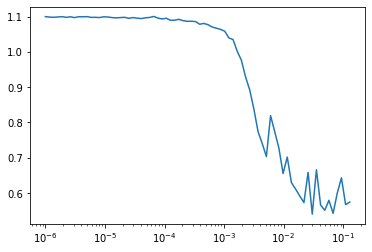

In [22]:
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=[LR_Find, Recorder])
run.fit(1000, learn)
run.recorder.plot(skip_last=5)

We should take the learning rate with the steepest drop, so somewhere between 1e-3 and 1e-2.

In [23]:
model = Classifier_CNN(nn.Sequential(
    *get_cnn_layers(raw_feat, output_shapes, kernels_shape, strides)
    ), emb_dims, num_classes).to(device)
opt = optim.Adam(model.parameters(), lr=2e-2)
cbfs = [Recorder, partial(AvgStatsCallback,adjusted_accu)]
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)
run.fit(50, learn)

epoch: 10
train: [1.095929463704427, tensor(0.3967)]
valid: [1.3562200927734376, tensor(0.3600)]
epoch: 20
train: [0.8562827555338541, tensor(0.5500)]
valid: [1.3453341674804689, tensor(0.3333)]
epoch: 30
train: [0.5564550272623698, tensor(0.7400)]
valid: [1.2367724609375, tensor(0.6133)]
epoch: 40
train: [0.4498468017578125, tensor(0.8100)]
valid: [1.7772005208333332, tensor(0.4667)]
epoch: 50
train: [0.428627675374349, tensor(0.8333)]
valid: [1.9154888916015624, tensor(0.5333)]


Even though this specific model didn't turn out to be too good, being correct in only approximately 60% of the time (there are 3 classes of which to choose), you can see how I again used a Callback to forward a metric which showed here as the accuracy.

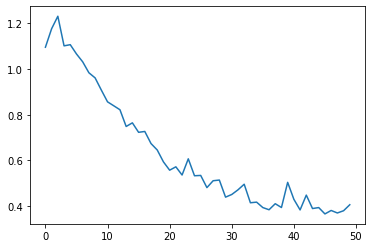

In [24]:
run.recorder.plot_loss()

Next to the validation set I also use the testset to check how good our predictions actually are.

In [25]:
outs = run.predict(learn, learn.data.test_dl)
outs[:10]

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
(outs == y_test).mean()

0.48

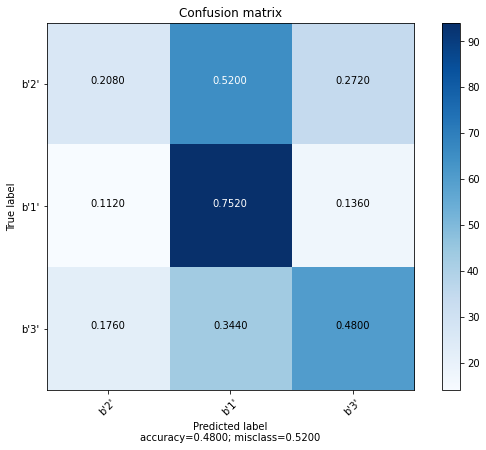

In [27]:
run.predict_metrics(learn, learn.data.test_dl, list(dict_y[0].values()))

We're pretty good at identifying class b1, however the model completely fails when it comes to classifying b2.

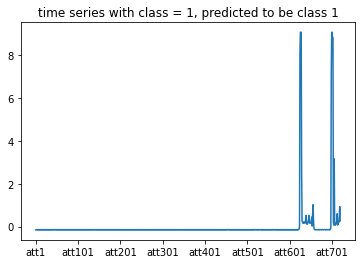

In [28]:
df_test.iloc[0, :-3].plot.line(title=f'time series with class = {df_test.iloc[0, -3]}, predicted to be class {outs[0]}');

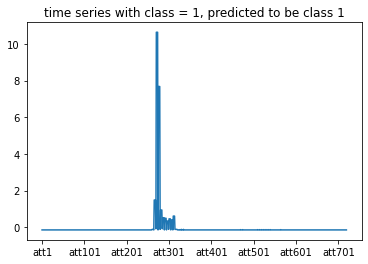

In [29]:
df_test.iloc[10, :-3].plot.line(title=f'time series with class = {df_test.iloc[10, -3]}, predicted to be class {outs[10]}');


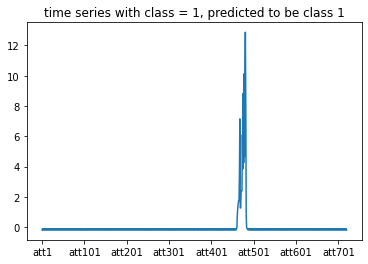

In [30]:
df_test.iloc[8, :-3].plot.line(title=f'time series with class = {df_test.iloc[8, -3]}, predicted to be class {outs[8]}');


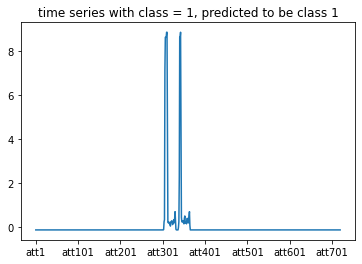

In [31]:
df_test.iloc[57, :-3].plot.line(title=f'time series with class = {df_test.iloc[57, -3]}, predicted to be class {outs[57]}');


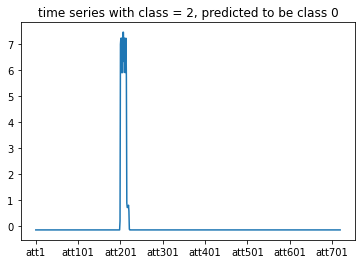

In [32]:
df_test.iloc[326, :-3].plot.line(title=f'time series with class = {df_test.iloc[326, -3]}, predicted to be class {outs[326]}');


Also one particular interesting measure is to look inside the model, meaning having a look at the means and standard-deviations of our activations. ideally the mean should be around 0 and the standard-variance about 1.

In [33]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [34]:
output_shapes = [128, 32, 64]
kernels_shape = [28, 14, 5]
strides = [7, 7, 2]

model = Classifier_CNN(nn.Sequential(
    *get_cnn_layers(raw_feat, output_shapes, kernels_shape, strides)
    ), emb_dims, num_classes).to(device)
    
model.raw[0][0].register_forward_hook(partial(append_stats, 0))
model.raw[1][0].register_forward_hook(partial(append_stats, 1))
model.raw[2][0].register_forward_hook(partial(append_stats, 2))

cbfs = [Recorder]
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

act_means = [[] for _ in range(3)]
act_stds  = [[] for _ in range(3)]

run.fit(50, learn)

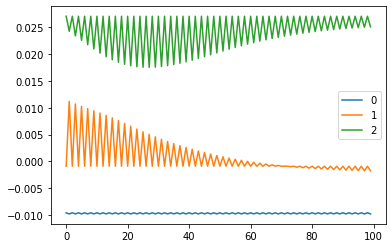

In [35]:
for o in act_means: plt.plot(o)
plt.legend(range(3));

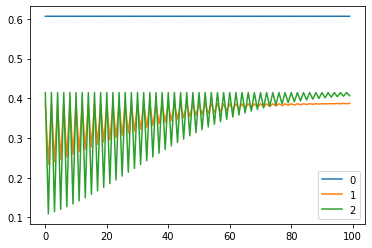

In [36]:
for o in act_stds: plt.plot(o)
plt.legend(range(3));

This is really interesting, this zigzag pattern in the later layers meaning we're actually not learning really well here. Let's try another, much simpler architecture and compare the results:

In [38]:
output_shapes = [128]
kernels_shape = [719]
strides = [1]

model = Classifier_CNN(nn.Sequential(
    *get_cnn_layers(raw_feat, output_shapes, kernels_shape, strides)
    ), emb_dims, num_classes).to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
cbfs = [Recorder]
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

act_means = [[] for _ in range(1)]
act_stds  = [[] for _ in range(1)]

model.raw[0][0].register_forward_hook(partial(append_stats, 0))

run.fit(50, learn)

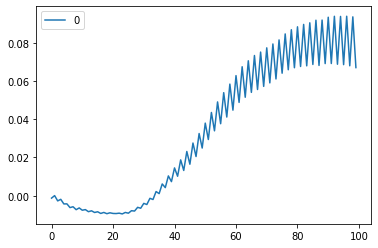

In [39]:
for o in act_means: plt.plot(o)
plt.legend(range(1));

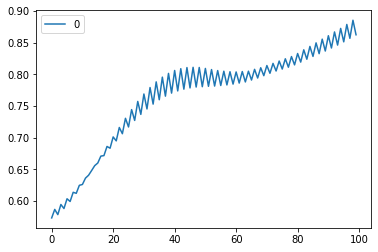

In [40]:
for o in act_stds: plt.plot(o)
plt.legend(range(1));

This looks better. However, we can also try a different initilization.

In [41]:
def init_weights(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)
output_shapes = [128, 32, 64]
kernels_shape = [28, 14, 5]
strides = [7, 7, 2]

model = Classifier_CNN(nn.Sequential(
    *get_cnn_layers(raw_feat, output_shapes, kernels_shape, strides)
    ), emb_dims, num_classes).to(device)

model.apply(init_weights)   

model.raw[0][0].register_forward_hook(partial(append_stats, 0))
model.raw[1][0].register_forward_hook(partial(append_stats, 1))
model.raw[2][0].register_forward_hook(partial(append_stats, 2))

cbfs = [Recorder]
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

act_means = [[] for _ in range(3)]
act_stds  = [[] for _ in range(3)]

run.fit(50, learn)

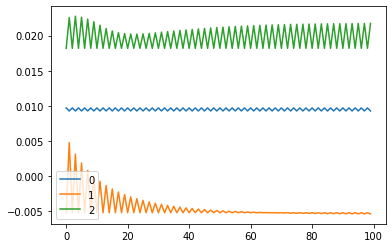

In [42]:
for o in act_means: plt.plot(o)
plt.legend(range(3));

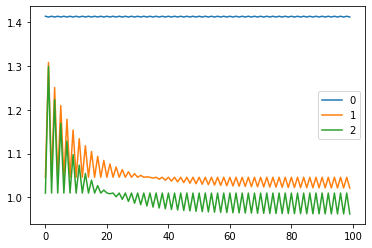

In [43]:
for o in act_stds: plt.plot(o)
plt.legend(range(3));

This looks way more promising when it comes to the 3 convolutional layers. Admittingly, this still is not perfect. 

In [44]:
model = Classifier_CNN(nn.Sequential(
    *get_cnn_layers(raw_feat, output_shapes, kernels_shape, strides)
    ), emb_dims, num_classes).to(device)

model.apply(init_weights)

opt = optim.Adam(model.parameters(), lr=2e-2)
cbfs = [Recorder, partial(AvgStatsCallback,adjusted_accu)]
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)
run.fit(80, learn)

epoch: 10
train: [1.0968295288085939, tensor(0.3433)]
valid: [1.9732820638020834, tensor(0.3867)]
epoch: 20
train: [0.7535211690266927, tensor(0.6067)]
valid: [1.5353872680664062, tensor(0.3867)]
epoch: 30
train: [0.5347029622395834, tensor(0.7467)]
valid: [1.365126953125, tensor(0.5333)]
epoch: 40
train: [0.4531549580891927, tensor(0.8067)]
valid: [2.0907596842447917, tensor(0.5600)]
epoch: 50
train: [0.36646458943684895, tensor(0.8233)]
valid: [3.187868448893229, tensor(0.4667)]
epoch: 60
train: [0.3460370127360026, tensor(0.8533)]
valid: [3.073258463541667, tensor(0.5333)]
epoch: 70
train: [0.3205308024088542, tensor(0.8467)]
valid: [3.1966796875, tensor(0.4933)]
epoch: 80
train: [0.3039264933268229, tensor(0.8500)]
valid: [3.1939200846354168, tensor(0.5867)]


In [45]:
outs = run.predict(learn, learn.data.test_dl)
(outs == y_test).mean()

0.448

This is the end of the first part of this tutorial. In the next tutorial I will show you how the code behind this looks like and how it works.

Lasse